## Solve Autoencoder and Eigenfunction of a 2D system

### load modules/packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import math 
import torch.nn as nn
import random
from tqdm import tqdm
import os
import sys
import time

# this line may need to be changed 
sys.path.append('./colvars-finder')

from colvarsfinder.core import AutoEncoderTask, EigenFunctionTask, RegAutoEncoderTask
from colvarsfinder.nn import AutoEncoder, EigenFunctions, RegAutoEncoder, RegModel 
from colvarsfinder.utils import WeightedTrajectory, integrate_sde_overdamped, calc_weights

###  defines potential of 2d system

In [2]:
            
class TripleWellPotAlongCircle :
    def __init__(self, beta, eps):
        self.beta = beta
        self.eps = eps 
        self.dim = 2

    def V(self, x):
      # angle in [-pi, pi] 

      theta = np.arctan2(x[1], x[0])
      # radius
      r = np.sqrt( x[0] * x[0] + x[1] * x[1] )

      v_vec = np.zeros(len(x))
      for idx in range(len(x)) :
          # potential V_1
          if theta > math.pi / 3 : 
            v_vec = (1-(theta * 3 / math.pi- 1.0)**2)**2
          if theta < - math.pi / 3 : 
            v_vec = (1-(theta * 3 / math.pi + 1.0)**2)**2
          if theta > - math.pi / 3 and theta < math.pi / 3:
            v_vec = 3.0 / 5.0 - 2.0 / 5.0 * np.cos(3 * theta)  
      # potential V_2
      v_vec = v_vec * 1.0 + (r - 1)**2 * 1.0 / self.eps + 5.0 * np.exp(-5.0 * r**2) 
      return v_vec

    def gradV(self, x): 
      # angle
      theta = np.arctan2(x[1], x[0])
      # radius
      r = np.sqrt( x[0] * x[0] + x[1] * x[1] )

      if np.fabs(r) < 1e-8: 
          print ("warning: radius is too small! r=%.4e" % r)
      dv1_dangle = 0.0
      # derivative of V_1 w.r.t. angle
      if theta > math.pi / 3: 
        dv1_dangle = 12 / math.pi * (theta * 3 / math.pi - 1) * ((theta * 3 / math.pi- 1.0)**2-1)
      if theta < - math.pi / 3: 
        dv1_dangle = 12 / math.pi * (theta * 3 / math.pi + 1) * ((theta * 3 / math.pi + 1.0)**2-1)
      if theta > -math.pi / 3 and theta < math.pi / 3:
        dv1_dangle = 1.2 * math.sin (3 * theta)
      # derivative of V_2 w.r.t. angle
      dv2_dangle = 0
      # derivative of V_2 w.r.t. radius
      dv2_dr = 2.0 * (r-1.0) / self.eps - 50.0 * r * np.exp(-r**2/0.2)

      return np.array((-(dv1_dangle + dv2_dangle) * x[1] / (r * r)+ dv2_dr * x[0] / r,  (dv1_dangle + dv2_dangle) * x[0] / (r * r)+ dv2_dr * x[1] / r))



### define parameters

In [3]:
def set_all_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
    random.seed(seed)
    
seed = 30
# certain potentials depend on epsilon 
eps = 0.5
beta = 1.0 

pot = TripleWellPotAlongCircle(beta, eps)
pot_name = type(pot).__name__

print ('potential name: %s' % pot_name) 

x_domain = [-3.5, 3.5]
y_domain = [-3.5, 3.5]

v_min_max = [0.3,8]

# for data generation
delta_t = 0.001
N = 500000

save_fig_to_file = False

# path to store log data
sys_path = pot_name 

print ('\nOutput directory: {}\n'.format(sys_path))

if not os.path.exists(sys_path):
    os.makedirs(sys_path)
    
set_all_seeds(seed)

potential name: TripleWellPotAlongCircle

Output directory: TripleWellPotAlongCircle



### visualise the potential

min and max values of potential: (0.0253, 32.0839)
(100, 150) (100, 150) (100, 150)


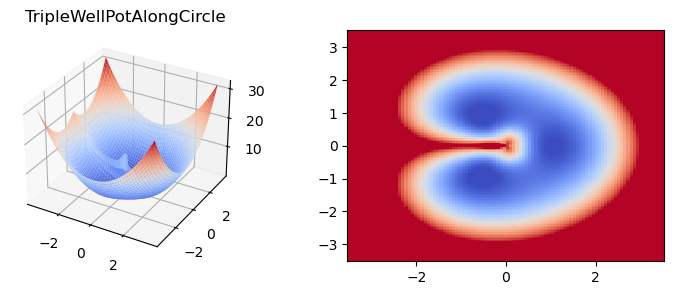

In [4]:
nx = 100
ny = 150
dx = (x_domain[1] - x_domain[0]) / nx
dy = (y_domain[1] - y_domain[0]) / ny

gridx = np.linspace(x_domain[0], x_domain[1], nx)
gridy = np.linspace(y_domain[0], y_domain[1], ny)
x_plot = np.outer(gridx, np.ones(ny)) 
y_plot = np.outer(gridy, np.ones(nx)).T 

x2d = np.concatenate((x_plot.reshape(nx * ny, 1), y_plot.reshape(nx * ny, 1)), axis=1)

pot_on_grid = np.array([pot.V(x) for x in x2d]).reshape(nx, ny)
print ( "min and max values of potential: (%.4f, %.4f)" % (pot_on_grid.min(), pot_on_grid.max()) )

fig = plt.figure(figsize=(9,3))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax1 = fig.add_subplot(1, 2, 2)
ax0.set_title(pot_name)
print (x_plot.shape, y_plot.shape, pot_on_grid.shape)

ax0.plot_surface(x_plot, y_plot, pot_on_grid, cmap='coolwarm', edgecolor='none')
ax1.pcolormesh(x_plot, y_plot, pot_on_grid, cmap='coolwarm',shading='auto', vmin=v_min_max[0], vmax=v_min_max[1])

if save_fig_to_file :
    filename = f"{sys_path}/{pot_name}.jpg" 
    fig.savefig(filename)
    print ( "potential profiles saved to file: %s" % filename )


### generate trajectory data

In [5]:
x_0 = np.array([0, 1])
traj_filename = 'traj.txt'
csv_filename = 'output.csv'

integrate_sde_overdamped(pot, N, sys_path, X0=x_0, pre_steps=0, step_size=delta_t, 
                         traj_txt_filename=traj_filename, csv_filename='output.csv', 
                         report_interval=100, report_interval_stdout=100000)


Directory to save trajectory ouptuts: TripleWellPotAlongCircle
sampling beta=1.000, dt=0.001

First, burning, total number of steps = 0
Next, run 500000 steps
step=0, time=0.000, energy=0.649
step=100000, time=100.000, energy=1.833
step=200000, time=200.000, energy=4.972
step=300000, time=300.000, energy=1.330
step=400000, time=400.000, energy=1.491


### calculate weights and show histogram


=============Calculate Weights============
Reading potential from: TripleWellPotAlongCircle/output.csv

Whole data:
    Time    Energy
0   0.0  0.648809
1   0.1  1.239862
2   0.2  0.898226
3   0.3  1.118336
4   0.4  1.385909
5   0.5  1.375917
6   0.6  0.547878
7   0.7  1.181500

Use 1th column to reweight, name: Energy

sampling beta=1.0, system beta=1.0

Weight:
    weight
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0 

Summary of weights:
        weight
count  5000.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
weights saved to: TripleWellPotAlongCircle/weights.txt

loading weights from file:  TripleWellPotAlongCircle/weights.txt

Weights:
 count    5000.0
mean        1.0
std         0.0
min         1.0
20%         1.0
40%         1.0
50%         1.0
60%         1.0
80%         1.0
max         1.0
Name: 0, dtype: float64

After selecting states whose weights are in [0.000e+00, inf] and renormaliza

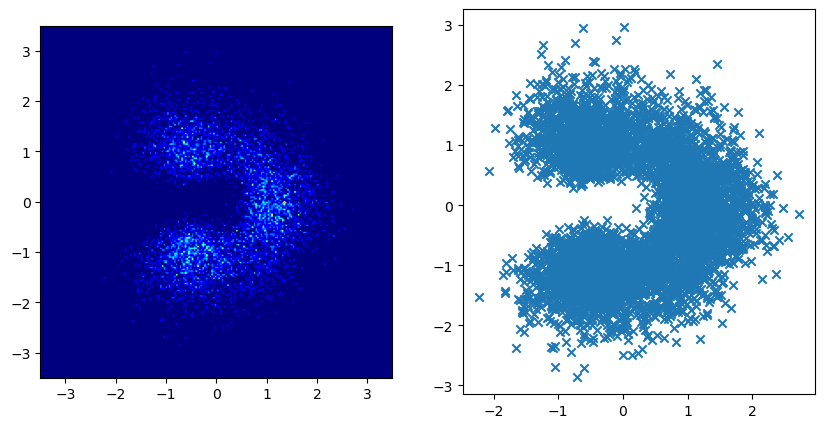

In [6]:
traj_weight_fullname = f'{sys_path}/weights.txt'
traj_fullname = f'{sys_path}/{traj_filename}'
csv_fullname = f'{sys_path}/{csv_filename}'

# we use the same temperature, so weights are all one
calc_weights(csv_fullname, pot.beta, pot.beta, traj_weight_filename=traj_weight_fullname)

trajectory = np.loadtxt(traj_fullname)

# construct trajectory class
traj = WeightedTrajectory(traj_filename=traj_fullname, weight_filename=traj_weight_fullname)


### Plot the trajectory 
fig = plt.figure(figsize=(10,5))
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)
nx = ny = 200
h = np.histogram2d(trajectory[:,1], trajectory[:,2], bins=[nx, ny], range=[[x_domain[0],x_domain[1]],[y_domain[0],y_domain[1]]])[0]
s = sum(sum(h))
im = ax0.imshow(h.T / (s * dx * dy), origin = "lower", \
                extent=[x_domain[0],x_domain[1],y_domain[0], y_domain[1]], \
                cmap=cm.jet, vmin=0.0, vmax=0.5)

ax1.scatter(trajectory[:,1], trajectory[:,2], marker='x')

if save_fig_to_file :
    filename = f"{sys_path}/traj.jpg" 
    fig.savefig(filename)
    print ("trajectory plot saved to file: %s" % filename)

### function to show the trained model

In [7]:
def plot_cv(cv_model):
    gridx = np.linspace(x_domain[0], x_domain[1], 100)
    gridy = np.linspace(y_domain[0], y_domain[1], 100)
    x_plot = np.outer(gridx, np.ones(100)) 
    y_plot = np.outer(gridy, np.ones(100)).T 
    # prepare data
    x2d = torch.from_numpy(np.concatenate((x_plot.reshape(100 * 100, 1), y_plot.reshape(100 * 100, 1)), axis=1)).float()
    # evaluate model on data
    cv_on_grid = cv_model(x2d).detach().numpy()

    for idx in range(k):
        cv = cv_on_grid[:,idx].reshape(100,100)
        #print ( "min and max values of %dth dimension of encoder: (%.4f, %.4f)" % (idx, encoder.min(), encoder.max()) )

        fig = plt.figure(figsize=(12,5))
        ax0 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1 = fig.add_subplot(1, 2, 2)  
        ax0.plot_surface(x_plot, y_plot, cv, cmap='coolwarm', edgecolor='none')
        im = ax1.pcolormesh(x_plot, y_plot, cv, cmap='coolwarm',shading='auto')
        contours = ax1.contour(x_plot, y_plot, cv, 20, colors='black')
        ax1.clabel(contours, inline=True, fontsize=8)
        fig.colorbar(im, ax=ax1)
        if save_fig_to_file :
            fig_name = f"{model_path}/cv_{idx}.jpg"
            fig.savefig(fig_name)
            #print ( "encoder profiles saved to file: %s" % fig_name )
            plt.close()
 

## common parameters

In [8]:
# use raw position data by setting preprocessing layer to identity
pp_layer = torch.nn.Identity()

batch_size = 1000
num_epochs = 200
test_ratio = 0.2
learning_rate = 0.005 
optimizer = 'Adam' # 'SGD'
k=1
pp_layer = torch.nn.Identity()

### learn autoencoder 


Training starts.
200 epochs in total, batch sizes (train/test): 1000/1000

Train set:
	4000 data, 4 iterations per epoch, 800 iterations in total.
Test set:
	1000 data, 1 iterations per epoch, 200 iterations in total.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:12<00:00, 15.68it/s]


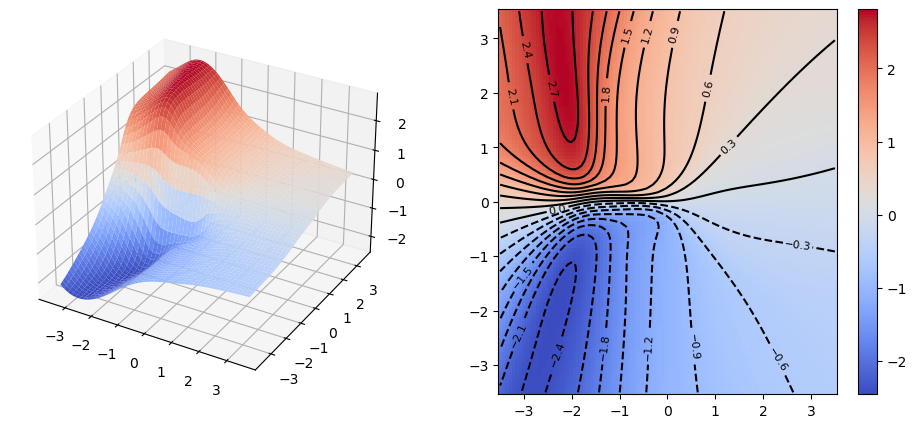

In [10]:
e_dims = [2, 20, 20, 20, k]
d_dims = [k, 20, 20, 2]
model = AutoEncoder(e_dims, d_dims)
model_path = os.path.join(sys_path, f'autoencoder-k={k}-' + time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime()))

# define training task
train_obj = AutoEncoderTask(traj, pp_layer, model, model_path, learning_rate=learning_rate, 
                            batch_size=batch_size, test_ratio=test_ratio, num_epochs=num_epochs,  verbose=False)

# train autoencoder
train_obj.train()

# get cv model
cv = train_obj.colvar_model()

# display results
plot_cv(cv)

## learn eigenfunction of generator


Training starts.
200 epochs in total, batch sizes (train/test): 1000/1000

Train set:
	4000 data, 4 iterations per epoch, 800 iterations in total.
Test set:
	1000 data, 1 iterations per epoch, 200 iterations in total.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:14<00:00, 13.89it/s]


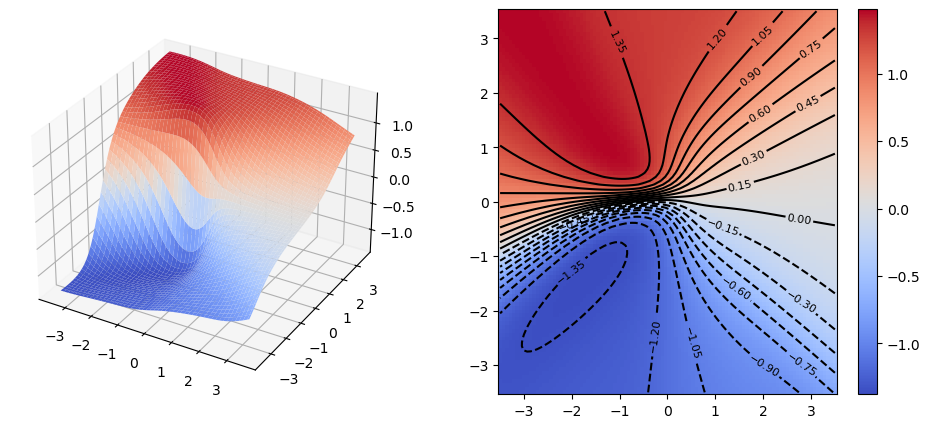

In [11]:

model = EigenFunctions([2, 20, 20, 20, 1], k)
model_path = os.path.join(sys_path, f'eigenfunction-k={k}-' + time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime()))
beta = 1.0
diag_coeff = torch.ones(2)
alpha = 20.0
eig_weights = [1.0]
lag_tau = 0.0
train_obj = EigenFunctionTask(traj, pp_layer, model, model_path, alpha, eig_weights, diag_coeff, beta, lag_tau, 
                              learning_rate=learning_rate, test_ratio=test_ratio, batch_size=batch_size, num_epochs=num_epochs,  verbose=False)
    
# train autoencoder
train_obj.train()

cv = train_obj.colvar_model()
plot_cv(cv)

## learn eigenfunction of transfer operator


Training starts.
200 epochs in total, batch sizes (train/test): 1000/1000

Train set:
	3998 data, 3 iterations per epoch, 600 iterations in total.
Test set:
	1000 data, 1 iterations per epoch, 200 iterations in total.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 16.94it/s]


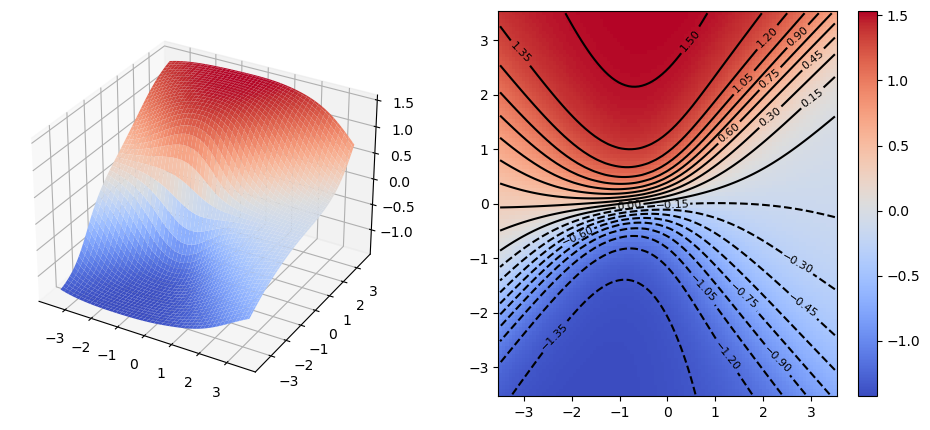

In [12]:

model = EigenFunctions([2, 20, 20, 20, 1], k)
model_path = os.path.join(sys_path, f'eigenfunction-k={k}-' + time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime()))
beta = 1.0
diag_coeff = torch.ones(2)
alpha = 20.0
eig_weights = [1.0]
lag_tau = 0.2
train_obj = EigenFunctionTask(traj, pp_layer, model, model_path, alpha, eig_weights, diag_coeff, beta, lag_tau, 
                              learning_rate=learning_rate, test_ratio=test_ratio, batch_size=batch_size, num_epochs=num_epochs,  verbose=False)
    
# train autoencoder
train_obj.train()

cv = train_obj.colvar_model()
plot_cv(cv)

## learn regularized autoencoder


Training starts.
200 epochs in total, batch sizes (train/test): 1000/1000

Train set:
	3999 data, 3 iterations per epoch, 600 iterations in total.
Test set:
	1000 data, 1 iterations per epoch, 200 iterations in total.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:14<00:00, 13.92it/s]


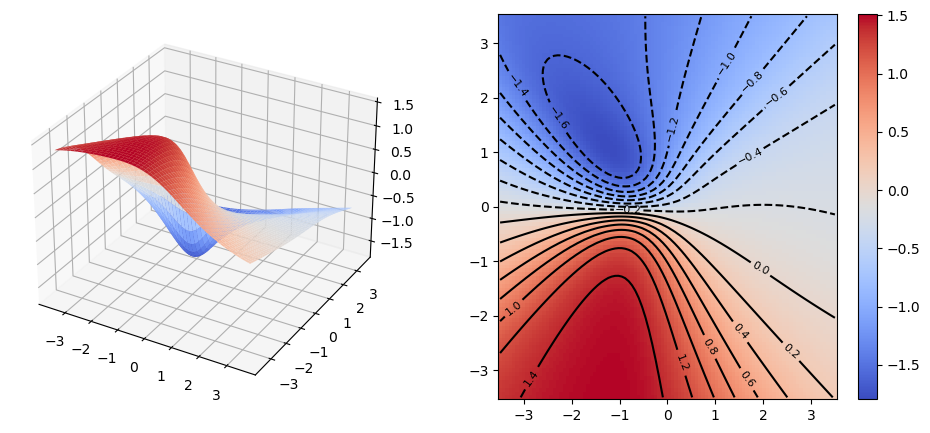

In [13]:
e_dims = [2, 20, 20, 20, 1]
d_dims = [1, 20, 20, 2]
r_dims = [1, 20, 20, 1]
model = RegAutoEncoder(e_dims, d_dims, r_dims, 1)
model_path = os.path.join(sys_path, f'regAE-k=1-' + time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime()))
beta = 1.0
diag_coeff = torch.ones(2)
alpha = 20.0
eig_weights = [1.0]
lag_tau = 0.2
train_obj = RegAutoEncoderTask(traj, pp_layer, model, model_path, eig_weights, gamma=[1,20], eta=[0,0,0], lag_tau_ae=0.1, lag_tau_reg=0.1,  
                              learning_rate=learning_rate, test_ratio=test_ratio, batch_size=batch_size, num_epochs=num_epochs,  verbose=False)
    
# train autoencoder
train_obj.train()

cv = train_obj.colvar_model()
plot_cv(cv)